# Liveability (Mmax) and survivable but not liveable matrix tutorial

This code will introduce you in the estimation of liveability matrices replicating graphs 4, S6, or S7 for maximum internal heat production (`Mmax`) and survivable but not liveable conditions (`survive_but_not_livable`) in Vanos et al. (2023). For this exercise, we are taking possible humidity values for temperatures between 25 and 60°C. Notice that radiation and wind are fixed here. Therefore, if your analysis has the same considerations, you could use these matrices as look-up tables. Otherwise, you will need to run the algorithm for each environmental condition and person setup. This analysis is intended for time frames that match global climate models with a temporal resolution of 3 and 6 hours once a sustained exposure is one of the steady-state model assumptions. 

**How is the maximum internal heat production (Mmax) defined as a liveability metric?**
`Mmax` is the maximum internal heat production, or level of physical activity, that a person can generate without a sustained positive rate of heat storage in the prevailing environment, thus allowing safe, sustained work and play for an extended period.

As part of liveability analysis, survivable but not liveable conditions `survive_but_not_livable`, in which people cannot increase their activity without continuously storing heat inside the body, which will lead to a continuous in core temperature, but heat stroke death after a 3-hour exposure would not occur.

**Disclaimer**: In this analysis, for the upper limit for survivable but not liveable conditions, we are using the survivability limit for a 3H exposure. That does not mean 3 hour is the duration for the safe, sustained activity that `Mmax` represent. `Mmax` is a threshold for the magnitude of internal heat production to keep the body upon compensable heat stress.

## Inputs
- Range of temperatures and humidity
- Type of humidity metric
- Personal profile description
- Matrix of wet bulb temperature (Tw) (This is only for comparison purposes with Tw=35°C)
- Survivability matrix (in this case, 3H exposure is used)
- Flag survivability that indicates the survivability type according to the physiological constraints imposed in this model (in this case, 3H exposure is used).

## Outputs
- **Liveability matrix (Mmax)**: Maximum metabolic rate to keep compensable heat stress (METs) (i.e., that a person can generate without a sustained positive rate of heat storage even with a maximal thermoregulatory response)
- **Survivable but not liveable matrix**: Flag that indicates if a person even upon uncompensable heat stress but if resting (minimal physical activity) can survive.
- **Plot of liveability estimates based on Mmax**, indicating too those conditions that are survivable but not livable, Survivability limit to 3H exposure and Tw=35 limit.

To obtain more details regarding the rationale behind these methods,look for session "methods" and their detail in the supplemental material in Vanos et al.(2023). 

Notice you need to change manually what type of humidity metric you want in the y-axis when indicated in the code with the `variable` version. You can choose between:

- rh: Relative humidity (%) 
- wv: Water vapor pressure (mmHg)
- q: Specific humidity (g/kg)

Also, you can set up the personal profile you want to consider in your analysis by changing the personal profile file and selecting the appropriate value for the variable `name_profile`.

Please cite the method Vanos, J., Guzman-Echavarria, G., Baldwin, J. W., Bongers, C., Ebi, K. L., & Jay, O. (2023). A physiological approach for assessing human survivability and liveability to heat in a changing climate. Nature Communications. Also, consider acknowledging this effort to make possible a straightforward application of this analysis, citing:
Guzman-Echavarria and Vanos (2023) Physiological-based estimations of human survivability and liveability to heat in a changing climate (V1.0.0) from Zenodo repository.

~Thanks to 	Haley Staudmyer for helping with feedback and comments implementing this tutorial.


# Loading packages and setting directories

In [1]:
#Loading needed packages to run the analysis as well as formatting for the plots (changes in the default runtime configuration rcParams).
import HHB as PyHHB
import numpy as np 
import pylab as plt 
import glob
import pandas as pd
import pickle
import matplotlib.gridspec as gridspec
from metpy.units import units
import metpy.calc as mpcalc


from matplotlib import rcParams
rcParams['legend.frameon']= False 
rcParams['legend.markerscale']=2.
rcParams['legend.fontsize']=14.
rcParams['axes.edgecolor']='0.8'
rcParams['axes.labelcolor']='0.15'
rcParams['axes.linewidth']='0.8'
rcParams['axes.labelsize']=14
rcParams['axes.titlesize']=19
rcParams[u'text.color']= u'.15'
rcParams[u'xtick.direction']= u'in'
rcParams[u'xtick.major.width']= 0.5
rcParams[u'xtick.labelsize']= 13
rcParams[u'ytick.labelsize']= 13
rcParams[u'ytick.color']=u'.15'
rcParams[u'ytick.direction']=u'in'
rcParams[ u'font.sans-serif']=[u'Arial',
                               u'Liberation Sans',
                               u'Bitstream Vera Sans',
                               u'sans-serif']
rcParams['hatch.linewidth'] = 1
    
import warnings
warnings.filterwarnings("ignore")

#To set legends
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [4]:
#Defining working directories (You need to change this to your local directory)
workdir = 'C:/Users/gguzma20/Dropbox (ASU)/Gisel PhD/Survivability Paper Development/Model_GitHub/PyHHB/'
#workdir = 'D:/Dropbox (ASU)/Gisel PhD/Survivability Paper Development/Model_GitHub/PyHHB/'

path_profiles  = workdir + 'personal_profiles/'
list_profiles = glob.glob(path_profiles+'*.txt') #To list all the profiles names in the folder

path_save = workdir + 'outputs/'#This is the folder in which all the outputs from this code will be saved.
path_icons = workdir + 'ancillary/'

Now, we are loading image icons to the custom `Mmax` colorbar. all icons comes from https://icons8.com/, Thanks for providing this material!)

Notice that the intensity of activities from `Mmax` are given in METs and the equivalent activities cames from Ainsworth et al. (2011).

*Ainsworth, B. E., Haskell, W. L., Herrmann, S. D., Meckes, N., Bassett, D. R., Tudor-Locke, C., Greer, J. L., Vezina, J., Whitt-Glover, M. C., & Leon, A. S. (2011). 2011 compendium of physical activities: A second update of codes and MET values. Medicine and Science in Sports and Exercise, 43(8), 1575–1581. https://doi.org/10.1249/MSS.0b013e31821ece12*

In [7]:
#Loading image icons to the custom Mmax colorbar 

#1.3 ~1.8   inactivity quiet/light sitting quietly, general,  sitting, fidgeting feet
sitting_icon = plt.imread(path_icons + 'icons8-relax-with-book-100.png')
studying_icon = plt.imread(path_icons + 'icons8-studying-64.png')
#2.3 - 2.5    walking      carrying 15 lb child, slow walking; bird watching, slow walk;  walking from house to car or bus, from car or bus to go places, from car or bus to and from the worksite
walking_icon = plt.imread(path_icons + 'icons8-walking-64.png')
#3.3  home activities cleaning, sweeping carpet or floors, general
cleaning_icon = plt.imread(path_icons + 'icons8-janitor-100.png')
#4.0 stair climbing, slow pace (17133)
stairclimbing_icon = plt.imread(path_icons + 'icons8-stair-climbing-100.png')
#5.0 dancing ballet, modern, or jazz, general, rehearsal or class
dancing_icon = plt.imread(path_icons + 'icons8-swing-100.png')
#7.0 running jogging, general
running_icon = plt.imread(path_icons + 'icons8-woman-athlete-100.png')
#7.5 occupation walking or walk downstairs or standing, carrying objects about 75 to 99 lbs
worker_icon = plt.imread(path_icons + 'icons8-heavy-100.png')

## Chosing fixed parameters in the model for this tutorial:

In [59]:
#Environmental settings
version = 'rh' # The humidity options are rh (relative humidity), wv (water vapor pressure), or q (specific humidity)
temperature = np.arange(25,60,0.1) #Create a range of temperatures we care about
sun = 'Night-Indoors' #Options are 'Night-Indoors','Day-Outdoors'
'see below in the code how the conditional is set for radiation to indicate wether the person is at shade or exposed to partly-cloudy conditions.'
Av_ms = 1 #Air velocity in (m/s)
barometric_pressure = 1013 #in hPa ONLY to obtain water vapor pressure when specific humidity is used as humidity metric.

#Personal profile settings
name_profile = 'Young_adult' #Options are'Young_adult','65_over'


#Time of exposure (temporal resolution of the climate model output)
exp_time = 3 

#Read in the heat of vaporisation of sweat at 30⁰C, 2426 J/g
Lh_vap = PyHHB.Lh_vap
Lh_vap

2426

## Input data set-up

In [9]:
#creation of the temperature,humidity matrices according the values set in the previous cell.
#Dealing with different types of humidity (input model is Ambient vapour pressure in kPa)
if version == 'rh':
    humidity =  np.arange(0.5,100.5,0.5)
    hum_label = 'Relative humidity (%)'
    xx_temp, yy_humidity = np.meshgrid(temperature, humidity)
    Psa_kPa = 	PyHHB.Psa_kPa_from_TaC(xx_temp)#Saturated vapor pressure in kPa
    Pv  =   PyHHB.Pv_kPa_from_Psa_RH(Psa_kPa,yy_humidity) #Water vapor pressure in kPa

if version == 'wv':
    humidity =  np.arange(0,42.25,0.25)#mmHg
    hum_label = 'Water vapor pressure (mmHg)'
    xx_temp, yy_humidity = np.meshgrid(temperature, humidity)
    Pv  =    (yy_humidity*units.mmHg).to('kPa').magnitude #Unit conversion from mmHg to kPa

if version == 'q': #Here we assume this is a location at sea level pressure.
    humidity = np.arange(0,40.2,0.2)
    hum_label = 'Specific humidity (g/kg)'
    xx_temp, yy_humidity = np.meshgrid(temperature, humidity)
    atm_sl_p = np.ones(xx_temp.shape)*barometric_pressure #Seting a
    yy_rh = mpcalc.relative_humidity_from_specific_humidity(atm_sl_p*units.hPa,xx_temp*units.degC, yy_humidity /1000)*100
    Psa_kPa = PyHHB.Psa_kPa_from_TaC(xx_temp)#Saturated vapor pressure in kPa
    Pv  =   PyHHB.Pv_kPa_from_Psa_RH(Psa_kPa,yy_rh) #Ambient vapor pressure in kPa

#Reading the Tw matrix that matches the humidity metric. These matrices were estimated previously using JPL Davies-Jones method.
WBT_matrix = pd.read_csv(workdir+'ancillary/'+version+'_version_WBT_matrix.csv', header = 0, index_col =0)


**Reading survivability to 3H heat exposure:**
To delimitate `survive_but_not_livable` conditions, we need to detect the extended environmental conditions in which a person is under uncompensable heat stress while resting but is not gaining enough heat to die by a heat-stroke for a given exposure time. Here we chose 3H as the exposure time for that evaluation and read the output files from the `SurvivabilityMatrix_Tutorial.ipynb`.

In [58]:
survivability      = pd.read_csv(path_save+version+'_survivability_array_'+sun+'_'+str(exp_time)+'H-'+name_profile+'.csv',index_col=0)  
flag_survivability = pd.read_csv(path_save+version+'_flag_survivability_'+sun+'_'+str(exp_time)+'H-'+name_profile+'.csv',index_col=0)  

,25.0,25.1,25.200000000000003,25.300000000000004,25.400000000000006,25.500000000000007,25.60000000000001,25.70000000000001,25.80000000000001,25.900000000000013,...,59.00000000000048,59.100000000000485,59.200000000000486,59.30000000000049,59.40000000000049,59.50000000000049,59.60000000000049,59.70000000000049,59.800000000000495,59.900000000000496
0.5,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1.0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1.5,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2.0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2.5,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98.0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
98.5,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
99.0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
99.5,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


**Reading the personal profile information:** This is the text file where you can customize anthropometrics, activities and clothing for your target population. To understand better the meaning, use and implications of human heat exchange, we recommend reading Cramer and Jay (2019).

*Cramer, M. N., & Jay, O. (2019). Cores of reproducibility in physiology partitional calorimetry. Journal of Applied Physiology, 126(2), 267–277. https://doi.org/10.1152/japplphysiol.00191.2018*

- `id`: identification of your profile
- `name`: name to add labels in the graphics (once this has spaces, it is not the best to use to save outputs
- `name_profile`: name of the text file with this information
- `Mass`: Mass of the human body (kg)
- `Height`: Height of the human body (m)
- `AD`: Dubois-Dubois surface corporal area (m2)
- `Tsk_C`: Mean skin temperature (⁰C)
- `A_eff`: Effective radiative area of the body (dimensionless)	
- `Emm_sk`: Area weighted emissivity of the clothed body surface (dimensionless)	
- `Icl`: Clothing insulation value (Iclo)	
- `Re_cl`: Evaporative heat transfer resistance of the clothing layer (m2·kPa/W)	
- `M`: (Hprod) Internal metabolic heat production in W/kg 
- `W`: External work performed by the person W/g (For this application W=0).
- `wmax_condition`: Maximum skin wettedness bibliography source to be set with PyHHB. (dimensionless)
- `smax_rate`: Maximum sustained sweat rate (L/hr)

**Disclaimer** `M` here is not the rate of metabolic energy expenditure as taken in Cramer and Jay, (2019) in Watts. For this application, we need the internal metabolic heat production to be a function of a person's weight. The reason behind that is to be able to calculate a maximum permissible net heat loss and thus asses if a linear increase of internal temperature with time will lead to a heat stroke death (See explanation in Vanos, et al. (2023)). 
`M` in this modeling effort represents internal metabolic heat production (Hprod = `M` - `W`), once we assume a null external work performed by the person (W=0).


Here, the value of `M`= 1.8 W/kg is equivalent to 1.5 MET, representing a person resting. To see the detail of the conversion factor from Watts to MET you can see the function documentation of `PyHHB.MetabolicRate_W_to_MET_Mass`.

**Disclaimer for liveability analysis:** The personal profile for liveability analysis is different from the survivability analysis in the `A_eff`, `Icl`, and `Re_cl` values because, in this analysis, we are considering people wearing light clothing and a sitting position, whereas in survivability analysis people is naked and lying down to be in coherence with Tw=35⁰C approach assumptions.

In [10]:
profile = PyHHB.read_personal_profiles(path_profiles + name_profile+'_livability.txt')
profile

{'id': '003',
 'name': '18-40 years',
 'name_file': 'Young_adult_livability',
 'Mass': '56.2',
 'Height': nan,
 'AD': '1.6',
 'Tsk_C': '35',
 'A_eff': '0.73',
 'Emm_sk': '0.98',
 'Icl': '0.36',
 'Re_cl': '0.01',
 'M': '1.8',
 'W': '0',
 'wmax_condition': 'YNG_Morris_2021',
 'smax_rate': '0.75'}

If the Dubois-Dubois surface corporal area `AD` is given in the profile file and is obtained from there. otherwise, it is estimated from `Mass` and `Height`:

In [14]:
if ~np.isfinite(float(profile['AD'])):
    AD    = PyHHB.AD_from_mass_height(float(profile['Mass']),float(profile['Height'])) #m2
else:
    AD = float(profile['AD'])

AD =  np.ones(xx_temp.shape)*AD

**Disclaimer**: To simulate a radiation condition representative for **shade or night time**, it is assumed that mean radiant temperature equals air temperature. For **sun-exposed conditions**, we asummed a hypothetical threshold to represent partly-cloudy conditions based on micro-climate measurements from Guzman-Echavarria et al (2022) paper. To do this analysis with actual radiation data, researchers should account for the estimations of mean radiant temperature or operative temperature with the outputs of the climate models.

*Guzman-Echavarria, G., Middel, A., & Vanos, J. (2022). Beyond heat exposure — new methods to quantify and link personal heat exposure, stress, and strain in diverse populations and climates: The journal temperature toolbox. Temperature, 10(03), 358–378. https://doi.org/10.1080/23328940.2022.2149024*

**Here, matrices for environmental variables are created or renamed for homogeneous formatting:** 

In [15]:
Ta_C = xx_temp
Pv_kPa  =   Pv
Av_ms  =  np.ones(xx_temp.shape)*Av_ms# Air velocity (m/s)

if sun == 'Night-Indoors':
    mrt_C  =  Ta_C#indoor mrt = Ta (⁰C)
elif sun == 'Day-Outdoors':
    mrt_C  =  Ta_C + 15 #outdoor mrt = Ta (⁰C) (Threshold to an hyphotetical Partly Cloudy Condition) based on the measurements from Guzman-Echavarria et al (2022)

else:
    raise ValueError("Non-valid radiation condition")

# Model run: estimation of liveability and survivable but not liveable matrix

### Estimation of the human-environment heat exchange avenues:
Setting the **internal heat production** (Hprod) term using `M` parameter from `profile` dictionary:

In [16]:
#Internal heat production at resting (W) equivalent to 1.5 METs
M =  np.ones(xx_temp.shape)* float(profile['M'])* float(profile['Mass']) #W/kg *Kg

**Estimation dry heat loss from the skin (combined heat flux via convection + radiation)**

In [18]:
# Defining properties to estimate the combined convective and radiative heat fluxes.
Tsk_C  = np.ones(xx_temp.shape)*float(profile['Tsk_C']) #Skin temperature, assumed to be held constant at 35°C
Emm_sk = np.ones(xx_temp.shape)*float(profile['Emm_sk']) #Area-weighted emissivity of the clothed body surface (dimensionless)
Ar_AD  = np.ones(xx_temp.shape)*float(profile['A_eff']) #Effective radiative area of the body (dimensionless)
Icl    = np.ones(xx_temp.shape)*float(profile['Icl']) #Insulation clothing value (CLO)


hc_cof  = PyHHB.hc_cof_from_Av(Av_ms) #W/m2K Convective heat transfer coefficient.
hr_cof  = PyHHB.hr_cof_from_radiant_features(mrt_C,Tsk_C,Emm_sk,Ar_AD) #Linear radiative heat transfer coefficient (W/m2K).
h_cof   = PyHHB.h_coef_from_hc_hr(hc_cof,hr_cof) # Combined heat transfer coefficient (W/m2K).
to_C    = PyHHB.to_from_hr_tr_hc_ta(hr_cof,mrt_C,hc_cof,Ta_C) #Operative temperature (⁰C)

#Estimation of combined dry heat loss via convection and radiation (W)
Dry_Heat_Loss =  PyHHB.Dry_Heat_Loss_c_plus_r(Tsk_C,to_C,Icl,h_cof,AD)

**Heat loss from respiration (Convection + Evaporation)**

In [19]:
# Estimation of dry respiratory heat loss (W)
Cres = PyHHB.Cres_from_M_Ta(M,Ta_C,AD)
# Estimation of latent respiratory heat loss (W)
Eres = PyHHB.Eres_from_M_Pa(M,Pv_kPa,AD)

Once we have all the avenues of heat exchange (Equation 4 in the supplemental material), we can estimate the **Evaporative required heat loss** `Ereq` (Equation 14 in the supplemental material).

In [20]:
Re_cl = np.ones(xx_temp.shape)*float(profile['Re_cl']) #Evaporative resistance of clothing in m2·kPa/W

#Estimation of evaporative required heat loss (W) 
Ereq = PyHHB.Ereq_from_HeatFluxes(M,0,Dry_Heat_Loss,Cres, Eres)

Now, we are getting closer, and we are ready to estimate the different evaporative heat loss restrictions (`Emax_env`, `Emax_wettedness`, and `Emax_sweat`) that will ultimately determine which is the most restrictive condition `Emax_lim` to determine if a person is under compensable heat stress using `PyHHB.livability_Mmax` function (See below, session *Liveability assessment*). 



**Estimation biophysical (environmental + clothing) evaporative heat loss limit**

This is directly linked with the humidity gradient between the environment and the skin surface and clothing resistance in the heat exchange (Equation 16 in the supplemental material). In very high humid climates, the drivers of evaporation are highly limiting.

In [22]:
#Water vapour pressure at the skin (kPa), assumed to be that of saturated water (100% HR) vapour at skin temperature.
Psk_s= PyHHB.Psa_kPa_from_TaC(Tsk_C) 
# Evaporative heat transfer coefficient (W/m2kPa).
he_cof = PyHHB.he_cof(hc_cof)

# Estimation of biophysical Emax (Env + clothing) (W)
Emax_env = PyHHB.Emax_env(Psk_s,Pv_kPa,Re_cl,he_cof,Icl,AD)
Emax_env[Emax_env<0] = 0 #This heat flux can not be negative.

**Estimation of the physiological (environmental + clothing + sweating capacity) evaporative heat loss limit**

This is linked with the physiological capacity to saturate the skin surface due to a limited maximum skin wettedness (`wmax`) given their age and/or degree of acclimation/acclimatization, among other factors. In this evaporative limit, the biophysical limit is scaled by the maximum skin wettedness (Equation 19 in the supplemental material).

In [23]:
# Maximum skin wettedness: maximum portion of total body surface area that can be saturated with sweat.
wmax = np.ones(xx_temp.shape)*PyHHB.wmax(profile['wmax_condition'])

# Physiological Emax (Env + clothing + wettedness) 
Emax_wettedness = PyHHB.Emax_wettedness(wmax,Psk_s,Pv_kPa,Re_cl,he_cof,Icl,AD)
Emax_wettedness[Emax_wettedness<0] = 0   #This heat flux can not be negative.  

**Estimation of the physiological evaporative heat loss limit given by sweat production**

In very hot and dry environments, evaporation is so efficient, and the sweating rate required to attain `Emax_env` may not be physiologically possible. The evaporative heat loss limit should account for the maximum rate (`Smax`, from `profile` dictionary) at which a person can segregate sweat. 

To be able to estimate the required sweat rate `Sreq` using the required evaporative heat loss to achieve heat balance `Ereq` , it is also necessary to know ahead of the expected sweating efficiency `r`, estimated as follows:

In [26]:
# Estimation of required skin wettedness (dimensionless)
wreq = PyHHB.wreq_HSI_skin_wettedness(Ereq,Emax_env)
# Estimation of expected sweating efficiency (dimensionless)
r = PyHHB.Sweating_efficiency_r(wreq) 
#Estimation of required sweat rate  to maintain heat balance (L/h).
Sreq =  PyHHB.Sreq(Ereq,r,Lh_vap)

**Disclaimer**:  `Emax_sweat` assumes that all sweat evaporates over the skin, and the heat loss is equivalent to the heat released by sweat's latent heat of vaporization.

In [25]:
Smax = np.ones(Ta_C.shape)*float(profile['smax_rate']) #Maximum sweat rate (L/h).

#Estimation of the physiological evaporative heat loss based on capacity to secret sweat
Emax_sweat = PyHHB.Emax_sweat_rate(Smax,Lh_vap,1,r)

## Liveability and survivable but not liveable assessment:

Now, we have all the elements needed to apply the workflow criteria to assess if a person can sustain compensable heat stress conditions and the maximum safe metabolic rate expressed in MET, and, therefore, known possible equivalent activities.

<img src="Liveability_method.png" alt="Liveability_method" width="500"/>

That workflow is implemented with the function `PyHHB.livability_Mmax` that takes `flag_survivability`, `Ereq`, `Emax_wettedness`, `Emax_sweat`,`M` to apply each criteria and provide two outputs.: 

`Mmax`: a float variable that expresses the maximum metabolic rate to keep compensable heat stress (METs) (i.e., that a person can generate without a sustained positive rate of heat storage even with a maximal thermoregulatory response)

`survive_but_not_livable`: a boolean (True, False) flag indicating if resting a person can survive even upon uncompensable heat stress (minimal physical activity).

Notice that:
- `Emax_lim` is the minimum value among `Emax_wettedness` and `Emax_sweat`
- `Hloss` can be represented either by (`Dry_Heat_Loss` +`Cres` +`Eres`) or (`Ereq` + `Hprod`), here is chosen the second option.




In [28]:
Mmax_W , survive_but_not_livable = PyHHB.livability_Mmax(flag_survivability,Ereq,Emax_wettedness,Emax_sweat,M)

**Disclaimer:** *Clothing* plays a complex role in heat stress, and the change from nudity to light clothing modifies the complete heat balance, making arid conditions less stressful. Therefore, we force to be non-livable the environmental conditions that are liveable in this analysis but not survivable to a 3H exposure.

In [31]:
Mmax_W[survivability == False] = np.nan
survive_but_not_livable = np.logical_and(survive_but_not_livable,survivability) #This line ensure too we doesn't extend past the new survivability curve

**Watts to METs conversion:**

All the avenues of heat exchange expressed in equation 4 (Supplemental material) are expressed in Watts. However, to provide a meaninful variable to communicate how liveability is impacted by heat, we chose to report `Mmax` in METs rather than Watts.

In [33]:
Mmax_MET = PyHHB.MetabolicRate_W_to_MET_Mass(Mmax_W,float(profile['Mass']))
Mmax_MET

array([[8.79763697, 8.77891763, 8.76019413, ...,        nan,        nan,
               nan],
       [8.77811456, 8.75927853, 8.74043773, ...,        nan,        nan,
               nan],
       [8.75859215, 8.73963943, 8.72068133, ...,        nan,        nan,
               nan],
       ...,
       [4.951722  , 4.91001445, 4.86818316, ...,        nan,        nan,
               nan],
       [4.93219959, 4.89037535, 4.84842676, ...,        nan,        nan,
               nan],
       [4.91267718, 4.87073625, 4.82867036, ...,        nan,        nan,
               nan]])

# Saving the matrices as text files

In [34]:
# Saving  Livability Mmax matrix as text file
dfMmax_MET = pd.DataFrame(index = humidity, columns = temperature)
dfMmax_MET[:] = Mmax_MET 
dfMmax_MET.to_csv(path_save_matrix+version+'_Mmax_Livability_'+sun+'_'+str(exp_time)+'H-'+name_profile+'.csv',header=True,index = True)

# Saving survivable but not liveable matrix as text file
dfsurvive_but_not_livable = pd.DataFrame(index = humidity, columns = temperature)
dfsurvive_but_not_livable[:] = survive_but_not_livable
dfsurvive_but_not_livable.to_csv(path_save_matrix+version+'_survive_but_not_livable_survivability_'+sun+'_'+str(exp_time)+'H-'+name_profile+'.csv',header=True,index = True)



# Now, the funniest part: plotting the results!

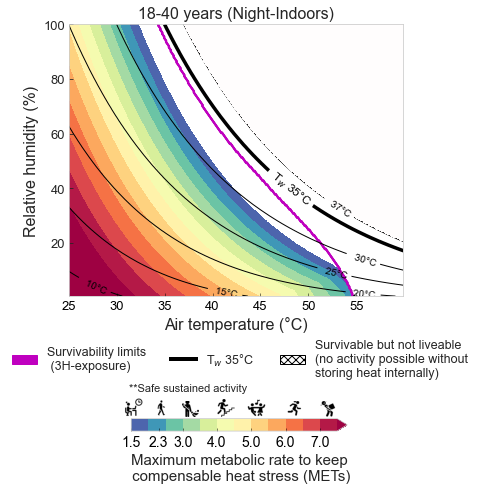

In [57]:
xx = xx_temp
yy = yy_humidity

#Setting up the color palette, bins and label for colorbar
colormap =  'Spectral_r'
levels = np.arange(1.5,8,0.5) 
unit_colores = 'Maximum metabolic rate to keep\n compensable heat stress (METs)'

plt.close('all')
fig = plt.figure(figsize=(6,5))
ax = plt.subplot('111')

#Plotting survibability line
cb = plt.contour(xx,yy,survivability,colors = 'm')
#Plotting  Mmax
cs = plt.contourf(xx,yy,Mmax_MET,cmap = colormap,levels= levels,extend = 'max')

#Ploting Tw
cp = plt.contour(xx,yy,WBT_matrix,colors = 'k', levels= [35],linewidths=(3.5,))
plt.clabel(cp, fmt = 'T$_w$ %2.1d°C', colors = 'k', manual= [(55,70)],fontsize=12) #contour line labels
#_____all lines but 35
p = list(np.arange(-10,40,5))
p.remove(35)
p.append(37)
cb = plt.contour(xx,yy,WBT_matrix,colors = 'Black',levels= p,linewidths=(1,))
plt.clabel(cb, fmt = ' %2.1d°C', colors = 'k', fontsize=10) #contour line labels

#Mask for values above Tw > 37°C because are not plausible to occur.
WBT_matrix[~np.isfinite(WBT_matrix)]= 40 #This line is just to do something with the values that are nan in WBT matrix   
plt.contourf(xx,yy,WBT_matrix[WBT_matrix>37],cmap = 'seismic',levels =[6,np.nanmax(WBT_matrix)],zorder =2)
       
        
#Setting plot labels
plt.title(profile['name'] + " ("+sun+")", fontsize = 16)
plt.xlabel('Air temperature (°C)', fontsize = 16)
plt.ylabel(hum_label,fontsize = 16)


#Setting colorbar (this is a long chunk of code)
cax = fig.add_axes([0.27, -0.25, 0.5, 0.035])
cbar = plt.colorbar(cs, cax=cax,pad=0.08,fraction=0.04,orientation = 'horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks([1.5,2.3,3,4,5,6,7,8])
cbar.set_label(unit_colores,fontsize = 15)
        

#1.3 ~ 1.8    inactivity quiet/light  sitting, work office ... meetings, studying
newax = fig.add_axes([0.245,-0.21,0.051,0.051], anchor='NE', zorder=1)
newax.imshow(studying_icon)
newax.axis('off')

#2.3 ~ 2.5    walking      carrying 15 lb child, slow walking; bird watching, slow walk; walking from house to car or bus, from car or bus to go places, from car or bus to and from the worksite
newax = fig.add_axes([0.31,-0.21,0.05,0.05], anchor='NE', zorder=1)
newax.imshow(walking_icon)
newax.axis('off')

#3.3  home activities cleaning, sweeping carpet or floors, general
newax = fig.add_axes([0.38,-0.21,0.045,0.045], anchor='NE', zorder=1)
newax.imshow(cleaning_icon)
newax.axis('off')

#4.0 Stair climbing
#stair climbing, slow pace (17133)
newax = fig.add_axes([0.46,-0.21,0.048,0.048], anchor='NE', zorder=1)
newax.imshow(stairclimbing_icon)
newax.axis('off')

#5.0 dancing ballet, modern, or jazz, general, rehearsal or class
newax = fig.add_axes([0.53,-0.21,0.05,0.05], anchor='NE', zorder=1)
newax.imshow(dancing_icon)
newax.axis('off')

#6.0 running Running, 4 mph (13 min/mile)
newax = fig.add_axes([0.62,-0.21,0.045,0.045], anchor='NE', zorder=1)
newax.imshow(running_icon)
newax.axis('off')

#7.5 occupation walking or walk downstairs or standing, carrying objects about 75 to 99 lbs
newax = fig.add_axes([0.7,-0.21,0.045,0.045], anchor='NE', zorder=1)
newax.imshow(worker_icon)
newax.axis('off')

#Setting legend (coordinates to locate it are regarding last axis wich is one of the icons)
legend_elements = [Patch(facecolor='m', edgecolor='m', label='Survivability limits\n (3H-exposure)'),
                   Line2D([0], [0], color='k', lw=4, label='T$_w$ 35°C'),
                   Patch(facecolor=(0,0,0,0), edgecolor='k',hatch='\\\\\///', label='Survivable but not liveable \n(no activity possible without \nstoring heat internally)')]


plt.legend(handles=legend_elements,bbox_to_anchor=(10,5.5),fontsize =12.5,ncol =3)
plt.text(0.18,-0.35,'**Safe sustained activity',transform=ax.transAxes,fontsize = 11) #Setting text legend

plt.savefig(path_save+version+'_livability_for_3HSurv_conditions'+sun+'_'+str(exp_time)+'H-'+name_profile+'.png',dpi=400,transparent=False,bbox_inches='tight')   
plt.show();plt.close()
